In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
pip show torchvision

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

Device: cuda:0


In [2]:
import json
import os
import torch.fx
import torchvision
from torchvision.io.video import read_video
from torchvision.models.video import r3d_18, R3D_18_Weights, mc3_18, MC3_18_Weights

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        with open(os.path.join(self.root_dir, 'annotations.json'), 'r') as f:
            self.annotations = json.load(f)

        self.clip_list = []
        self.label_list = []
        for actions in self.annotations['Actions']:
            severity_class = self.annotations['Actions'][actions]['Severity']
            offence_class = self.annotations['Actions'][actions]['Offence']
            action_class = self.annotations['Actions'][actions]['Action class']
            path_clip = os.path.join(self.root_dir, "action_" + str(actions))
            if (offence_class == '' or offence_class == 'Between') and action_class != 'Dive':
                continue
            if (severity_class == '' or severity_class == '2.0' or severity_class == '4.0') and action_class != 'Dive' and offence_class != 'No offence':
                continue
            if offence_class == '' or offence_class == 'Between':
                offence_class == 'Offence'
            for i in range(len(self.annotations['Actions'][actions]['Clips'])):
                if offence_class == 'No offence':
                    self.label_list.append([1,0,0,0])
                    if i == 0:
                        path_clip_0 = os.path.join(path_clip, "clip_0.mp4")
                        self.clip_list.append(path_clip_0)
                    elif i == 1:
                        path_clip_1 = os.path.join(path_clip, "clip_1.mp4")
                        self.clip_list.append(path_clip_1)
                    elif i == 2 and os.path.exists(os.path.join(path_clip, "clip_2.mp4")):
                        path_clip_2 = os.path.join(path_clip, "clip_2.mp4")
                        self.clip_list.append(path_clip_2)
                    elif i == 3 and os.path.exists(os.path.join(path_clip, "clip_3.mp4")):
                        path_clip_3 = os.path.join(path_clip, "clip_3.mp4")
                        self.clip_list.append(path_clip_3)
                elif offence_class == 'Offence' and severity_class == '1.0' or severity_class == '2.0':
                    self.label_list.append([0,1,0,0])
                    if i == 0:
                        path_clip_0 = os.path.join(path_clip, "clip_0.mp4")
                        self.clip_list.append(path_clip_0)
                    elif i == 1:
                        path_clip_1 = os.path.join(path_clip, "clip_1.mp4")
                        self.clip_list.append(path_clip_1)
                    elif i == 2 and os.path.exists(os.path.join(path_clip, "clip_2.mp4")):
                        path_clip_2 = os.path.join(path_clip, "clip_2.mp4")
                        self.clip_list.append(path_clip_2)
                    elif i == 3 and os.path.exists(os.path.join(path_clip, "clip_3.mp4")):
                        path_clip_3 = os.path.join(path_clip, "clip_3.mp4")
                        self.clip_list.append(path_clip_3)
                elif offence_class == 'Offence' and severity_class == '3.0' or severity_class == '4.0':
                    self.label_list.append([0,0,1,0])
                    if i == 0:
                        path_clip_0 = os.path.join(path_clip, "clip_0.mp4")
                        self.clip_list.append(path_clip_0)
                    elif i == 1:
                        path_clip_1 = os.path.join(path_clip, "clip_1.mp4")
                        self.clip_list.append(path_clip_1)
                    elif i == 2 and os.path.exists(os.path.join(path_clip, "clip_2.mp4")):
                        path_clip_2 = os.path.join(path_clip, "clip_2.mp4")
                        self.clip_list.append(path_clip_2)
                    elif i == 3 and os.path.exists(os.path.join(path_clip, "clip_3.mp4")):
                        path_clip_3 = os.path.join(path_clip, "clip_3.mp4")
                        self.clip_list.append(path_clip_3)
                elif offence_class == 'Offence' and severity_class == '5.0':
                    self.label_list.append([0,0,0,1])
                    if i == 0:
                        path_clip_0 = os.path.join(path_clip, "clip_0.mp4")
                        self.clip_list.append(path_clip_0)
                    elif i == 1:
                        path_clip_1 = os.path.join(path_clip, "clip_1.mp4")
                        self.clip_list.append(path_clip_1)
                    elif i == 2 and os.path.exists(os.path.join(path_clip, "clip_2.mp4")):
                        path_clip_2 = os.path.join(path_clip, "clip_2.mp4")
                        self.clip_list.append(path_clip_2)
                    elif i == 3 and os.path.exists(os.path.join(path_clip, "clip_3.mp4")):
                        path_clip_3 = os.path.join(path_clip, "clip_3.mp4")
                        self.clip_list.append(path_clip_3)
                else:
                    continue

    def __len__(self):
        return len(self.clip_list)
    
    def __getitem__(self, idx):
        severity = self.label_list[idx]
        clip = self.clip_list[idx]

        vid, _, _ = read_video(clip, output_format="TCHW")
        vid = vid[:53] 
        
        #FOR R3D_18:
        weights = R3D_18_Weights.DEFAULT
        preprocess = weights.transforms()
        clip = preprocess(vid).unsqueeze(0)

        #FOR MC3_18:
        #weights = MC3_18_Weights.DEFAULT
        #preprocess = weights.transforms()
        #clip = preprocess(vid).unsqueeze(0)

        severity = torch.tensor(severity)
        clip = clip.squeeze()

        return severity, clip

In [3]:
Train = CustomDataset(r"C:\Uni\Year3\Thesis\dataset\Train")
Validate = CustomDataset(r"C:\Uni\Year3\Thesis\dataset\Valid")
Test = CustomDataset(r"C:\Uni\Year3\Thesis\dataset\Test")

dataloader_Train = torch.utils.data.DataLoader(Train, batch_size=4, shuffle=True, drop_last=True)
dataloader_Validate = torch.utils.data.DataLoader(Validate, batch_size=4, shuffle=False, drop_last=True)
dataloader_Test = torch.utils.data.DataLoader(Test, batch_size=4, shuffle=False, drop_last=True)

In [4]:
class_weights = torch.tensor([0.0897, 0.0223, 0.0394, 0.8486])

In [5]:
import gc

def show_cache():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print(f"{torch.cuda.memory_allocated()/(1024)} Kb")

show_cache()

0.0 Kb


In [6]:
from torch import nn
import torch.nn.functional
from torchvision import transforms

transform_train = transforms.Compose([
   transforms.RandomHorizontalFlip(p=0.5),
   transforms.RandomResizedCrop(size=112, scale=(0.8, 1.0)),
   transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6),
   transforms.RandomRotation(degrees=10),
])

Train = CustomDataset(r"C:\Uni\Year3\Thesis\dataset\Train", transform=transform_train)
dataloader_Train = torch.utils.data.DataLoader(Train, batch_size=4, shuffle=True, drop_last=True)

weights = R3D_18_Weights.DEFAULT
model = r3d_18(weights=weights)
crossloss = nn.CrossEntropyLoss(weight=class_weights.cuda())
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 4)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=0.01)
model = model.to(device)
model.train() 

loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []

for epoch in range(10):
   total_loss = 0
   total_correct = 0
   total_samples = 0
   for label, clips in dataloader_Train:
      label = label.to(device).float()
      clips = clips.to(device).float()  
      optimizer.zero_grad()
      
      predictions = model(clips)
      loss = crossloss(predictions, label.argmax(dim=1)) 

      loss.backward()
      optimizer.step()

      total_loss += loss.item() * clips.size(0)
      total_correct += torch.eq(predictions.argmax(dim=1), label.argmax(dim=1)).sum().item()
      total_samples += clips.size(0)

   epoch_loss = total_loss / total_samples
   epoch_acc = total_correct / total_samples
   print(f"Epoch {epoch}: loss={epoch_loss:.4f}, accuracy={epoch_acc:.4f}")
   loss_list_train.append(round(epoch_loss, 4))
   accuracy_list_train.append(round(epoch_acc, 4))

   with torch.no_grad():
      total_loss = 0
      total_correct = 0
      total_samples = 0
      for label, clips in dataloader_Validate:
         label = label.to(device).float()
         clips = clips.to(device).float()  
         
         predictions = model(clips)
         loss = crossloss(predictions, label.argmax(dim=1))

         total_loss += loss.item() * clips.size(0)
         total_correct += torch.eq(predictions.argmax(dim=1), label.argmax(dim=1)).sum().item()
         total_samples += clips.size(0)

      epoch_loss = total_loss / total_samples
      epoch_acc = total_correct / total_samples
      print(f"Epoch {epoch}: loss={epoch_loss:.4f}, accuracy={epoch_acc:.4f}")
      loss_list_val.append(round(epoch_loss, 4))
      accuracy_list_val.append(round(epoch_acc, 4))
   
   torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

   gc.collect()
   torch.cuda.empty_cache()

c:\Users\Daan-\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\io\video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


Epoch 0: loss=1.2705, accuracy=0.4436
Epoch 0: loss=1.1287, accuracy=0.5599
Epoch 1: loss=1.2473, accuracy=0.4897
Epoch 1: loss=1.2019, accuracy=0.4727
Epoch 2: loss=1.2442, accuracy=0.4791
Epoch 2: loss=1.1640, accuracy=0.5599
Epoch 3: loss=1.2480, accuracy=0.4897
Epoch 3: loss=1.1368, accuracy=0.5104
Epoch 4: loss=1.2437, accuracy=0.5038
Epoch 4: loss=1.1450, accuracy=0.5599
Epoch 5: loss=1.2358, accuracy=0.5164
Epoch 5: loss=1.1382, accuracy=0.5143
Epoch 6: loss=1.2330, accuracy=0.5152
Epoch 6: loss=1.1483, accuracy=0.5547
Epoch 7: loss=1.2335, accuracy=0.5222
Epoch 7: loss=1.1400, accuracy=0.5599
Epoch 8: loss=1.2339, accuracy=0.5239
Epoch 8: loss=1.1595, accuracy=0.5599
Epoch 9: loss=1.2334, accuracy=0.5186
Epoch 9: loss=1.1318, accuracy=0.5599


In [ ]:
from torch import nn
import torch.nn.functional

weights_3 = MC3_18_Weights.DEFAULT
model_3 = mc3_18(weights=weights_3)
crossloss = nn.CrossEntropyLoss(weight=class_weights.cuda())
in_features = model_3.fc.in_features
model_3.fc = nn.Linear(in_features, 4)
optimizer = torch.optim.Adam(model_3.parameters(),lr=0.0001, weight_decay=0.01)
model_3 = model_3.to(device)
model_3.train() 

loss_list_train = []
loss_list_val = []
accuracy_list_train = []
accuracy_list_val = []

confusion_matrix_test = None

for epoch in range(10):
   total_loss = 0
   total_correct = 0
   total_samples = 0
   for label, clips in dataloader_Train:
      label = label.to(device).float()
      clips = clips.to(device).float()  
      optimizer.zero_grad()
      
      predictions = model_3(clips)
      loss = crossloss(predictions, label.argmax(dim=1)) 

      loss.backward()
      optimizer.step()

      total_loss += loss.item() * clips.size(0)
      total_correct += torch.eq(predictions.argmax(dim=1), label.argmax(dim=1)).sum().item()
      total_samples += clips.size(0)

   epoch_loss = total_loss / total_samples
   epoch_acc = total_correct / total_samples
   print(f"Epoch {epoch}: loss={epoch_loss:.4f}, accuracy={epoch_acc:.4f}")
   loss_list_train.append(round(epoch_loss, 4))
   accuracy_list_train.append(round(epoch_acc, 4))

   with torch.no_grad():
      total_loss = 0
      total_correct = 0
      total_samples = 0
      for label, clips in dataloader_Validate:
         label = label.to(device).float()
         clips = clips.to(device).float()  
         
         predictions = model_3(clips)
         loss = crossloss(predictions, label.argmax(dim=1))

         total_loss += loss.item() * clips.size(0)
         total_correct += torch.eq(predictions.argmax(dim=1), label.argmax(dim=1)).sum().item()
         total_samples += clips.size(0)

      epoch_loss = total_loss / total_samples
      epoch_acc = total_correct / total_samples
      print(f"Epoch {epoch}: loss={epoch_loss:.4f}, accuracy={epoch_acc:.4f}")
      loss_list_val.append(round(epoch_loss, 4))
      accuracy_list_val.append(round(epoch_acc, 4))
   
   torch.save(model_3.state_dict(), f"model_3_epoch_{epoch}.pth")

   gc.collect()
   torch.cuda.empty_cache()

In [ ]:
from torch import nn
import torch.nn.functional
from torchvision import transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

model_3 = mc3_18()
crossloss = nn.CrossEntropyLoss(weight=class_weights.cuda())
in_features = model_3.fc.in_features
model_3.fc = nn.Linear(in_features, 4)
model_3.load_state_dict(torch.load("model_3_epoch_9.pth"))
model_3 = model_3.to(device)
model_3.train() 

confusion_matrix_test = None

with torch.no_grad():
      model_3.eval()
      total_loss = 0
      total_correct = 0
      total_samples = 0
      all_targets = []
      all_predictions = []
      for label, clips in dataloader_Test:
         label = label.to(device).float()
         clips = clips.to(device).float()  
         
         predictions = model_3(clips)
         loss = crossloss(predictions, label.argmax(dim=1))

         total_loss += loss.item() * clips.size(0)
         total_correct += torch.eq(predictions.argmax(dim=1), label.argmax(dim=1)).sum().item()
         total_samples += clips.size(0)

         all_targets.append(label.argmax(dim=1).cpu())
         all_predictions.append(predictions.argmax(dim=1).cpu())

      epoch_loss = total_loss / total_samples
      epoch_acc = total_correct / total_samples
      print(f"loss={epoch_loss:.4f}, accuracy={epoch_acc:.4f}")
      all_targets = np.concatenate(all_targets)
      all_predictions = np.concatenate(all_predictions)
      confusion_matrix_test = confusion_matrix(all_targets, all_predictions)

      print(classification_report(all_targets, all_predictions, target_names=["No Foul","Foul","Foul+Yellow","Foul+Red"]))
      disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test,display_labels=["No Foul","Foul","Foul+Yellow","Foul+Red"])
      disp.plot()
      plt.show()

In [ ]:
import pprint
from torch import nn

#torch.save(model.state_dict(), "R3D_18_1.pth")

#weights = R3D_18_Weights.DEFAULT
#model = r3d_18(weights=weights)
#in_features = model.fc.in_features
#model.fc = nn.Linear(in_features, 4)
#pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(model.state_dict())

In [ ]:
#in_features = model.fc.in_features
#model.fc = nn.Linear(in_features, 4)
#model.load_state_dict(torch.load("R3D_18_TRain.pth"))
#pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(model.state_dict())

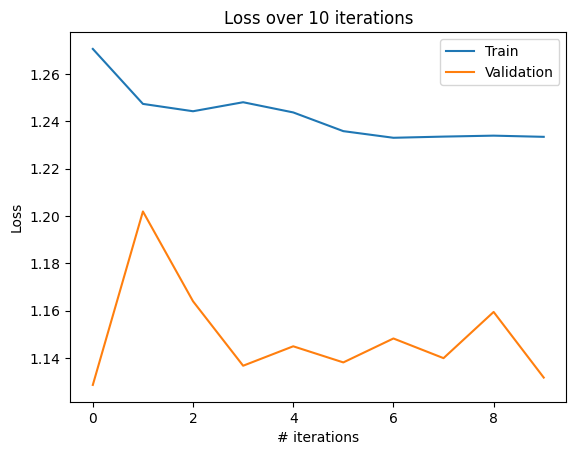

In [7]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0,len(loss_list_train))
plt.plot(x, loss_list_train, label = "Train" )
plt.plot(x, loss_list_val, label = "Validation" )
plt.title("Loss over 10 iterations") 
plt.legend()
plt.xlabel("# iterations")
plt.ylabel("Loss")
plt.show()

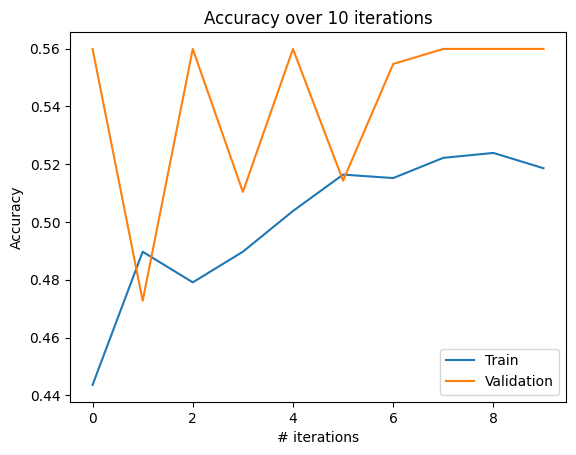

In [8]:
x = np.arange(0,len(accuracy_list_train))
plt.plot(x, accuracy_list_train, label = "Train" )
plt.plot(x, accuracy_list_val, label = "Validation" )
plt.title("Accuracy over 10 iterations") 
plt.legend()
plt.xlabel("# iterations")
plt.ylabel("Accuracy")
plt.show()